# Airfoil optimization

In [13]:
from IPython.display import SVG, display


#stuff for neurofoil - pip install neuralfoil
from aerosandbox.geometry.airfoil.airfoil_families import get_kulfan_parameters, get_kulfan_coordinates
import aerosandbox as asb
import aerosandbox.numpy as np
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p


import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

import sys
import os

## Procedure 

Sources:
* http://servidor.demec.ufpr.br/CFD/bibliografia/aerodinamica/kulfan_2007.pdf
* https://www.tandfonline.com/doi/epdf/10.1080/19942060.2024.2445144
* https://github.com/peterdsharpe/NeuralFoil


Here the PINN is allready trained an provides the prediction. Therefore, the idea is, we shift the quantum opt. part to approximate a policy. 

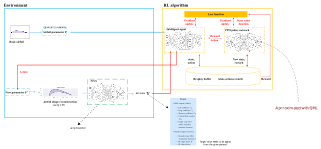

In [14]:
display(SVG(filename="optimprocedure.svg"))

In [ ]:
sys.path.append(os.path.abspath("../blade_design_tools"))
import create_airfoil
airfoil_top_points, airfoil_bottom_points, camber_curve_points = create_airfoil.generate_shape(config_filepath="../blade_design_tools/airfoil_config.yaml")

In [ ]:
def get_neuralfoil_coordinates(airfoil_top_points, airfoil_bottom_points):
    """
        stacking is up for neurofoil
    """
    # Upper surface: reverse to go from TE to LE
    upper_te_to_le = np.flip(airfoil_top_points, axis=0)

    # Lower surface: LE to TE as is
    lower_le_to_te = airfoil_bottom_points

    # Check if LE points match (for sharp LE); avoid duplicating if so
    if np.allclose(upper_te_to_le[-1], lower_le_to_te[0]):
        coordinates = np.vstack((upper_te_to_le, lower_le_to_te[1:]))
    else:
        coordinates = np.vstack((upper_te_to_le, lower_le_to_te))
    return coordinates


# 7. Export for NeuralFoil
coordinates = get_neuralfoil_coordinates(airfoil_top_points, airfoil_bottom_points)
kulfan_params = get_kulfan_parameters(coordinates)
print("Kulfan parameters:", kulfan_params)

In [5]:
kulfan_airfoil = asb.KulfanAirfoil(name="State p'", **kulfan_params)

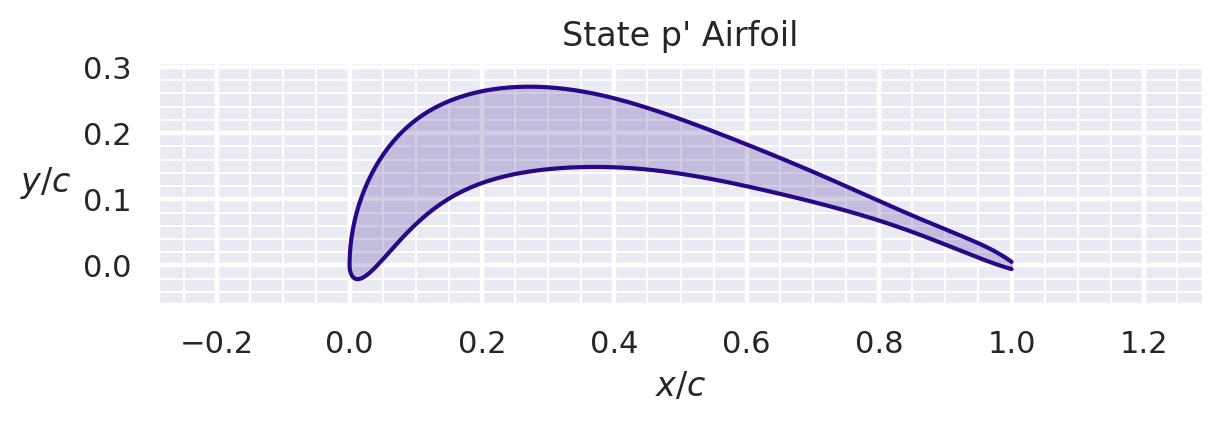

In [6]:
fig, ax = plt.subplots(figsize=(6, 2))
kulfan_airfoil.draw()

In [7]:
initial_guess_airfoil = kulfan_airfoil
opti = asb.Opti()

In [8]:
CL_multipoint_targets = np.array([0.8, 1.0, 1.2, 1.4, 1.5, 1.6])
CL_multipoint_weights = np.array([5, 6, 7, 8, 9, 10])

Re = 500e3 * (CL_multipoint_targets / 1.25) ** -0.5
mach = 0.7

In [9]:
optimized_airfoil = asb.KulfanAirfoil(
    name="Optimized",
    lower_weights=opti.variable(
        init_guess=initial_guess_airfoil.lower_weights,
        lower_bound=-0.5,
        upper_bound=0.25,
    ),
    upper_weights=opti.variable(
        init_guess=initial_guess_airfoil.upper_weights,
        lower_bound=-0.25,
        upper_bound=0.5,
    ),
    leading_edge_weight=opti.variable(
        init_guess=initial_guess_airfoil.leading_edge_weight,
        lower_bound=-1,
        upper_bound=1,
    ),
    TE_thickness=kulfan_params["TE_thickness"],
)

alpha = opti.variable(
    init_guess=45
)

In [10]:
aero = optimized_airfoil.get_aero_from_neuralfoil(
    alpha=alpha,
    Re=Re,
    mach=mach,
)

# Test optimization frame work
### TODO's: 
- Implement real costfunction
- Shape constraints
- Implement the PPO, here we compare standard PPO vs. Quantum PPO

In [ ]:
opti.subject_to([
    aero["analysis_confidence"] > 0.90,
    aero["CL"] == CL_multipoint_targets,
    np.diff(alpha) > 0,
    aero["CM"] >= -0.133,
    optimized_airfoil.local_thickness(x_over_c=0.33) >= 0.128,
    optimized_airfoil.local_thickness(x_over_c=0.90) >= 0.014,
    optimized_airfoil.TE_angle() >= 6.03, 
    optimized_airfoil.lower_weights[0] < -0.05,
    optimized_airfoil.upper_weights[0] > 0.05,
    optimized_airfoil.local_thickness() > 0
])

get_wiggliness = lambda af: sum([
    np.sum(np.diff(np.diff(array)) ** 2)
    for array in [af.lower_weights, af.upper_weights]
])

opti.subject_to(
    get_wiggliness(optimized_airfoil) < 2 * get_wiggliness(initial_guess_airfoil)
)


# Formulate an optimization goal based
opti.minimize(np.mean(aero["CD"] * CL_multipoint_weights))

sol = opti.solve(
    behavior_on_failure="return_last",
    options={
        "ipopt.mu_strategy": 'monotone',
        "ipopt.start_with_resto": 'yes'
    }
)

optimized_airfoil = sol(optimized_airfoil)
aero = sol(aero)

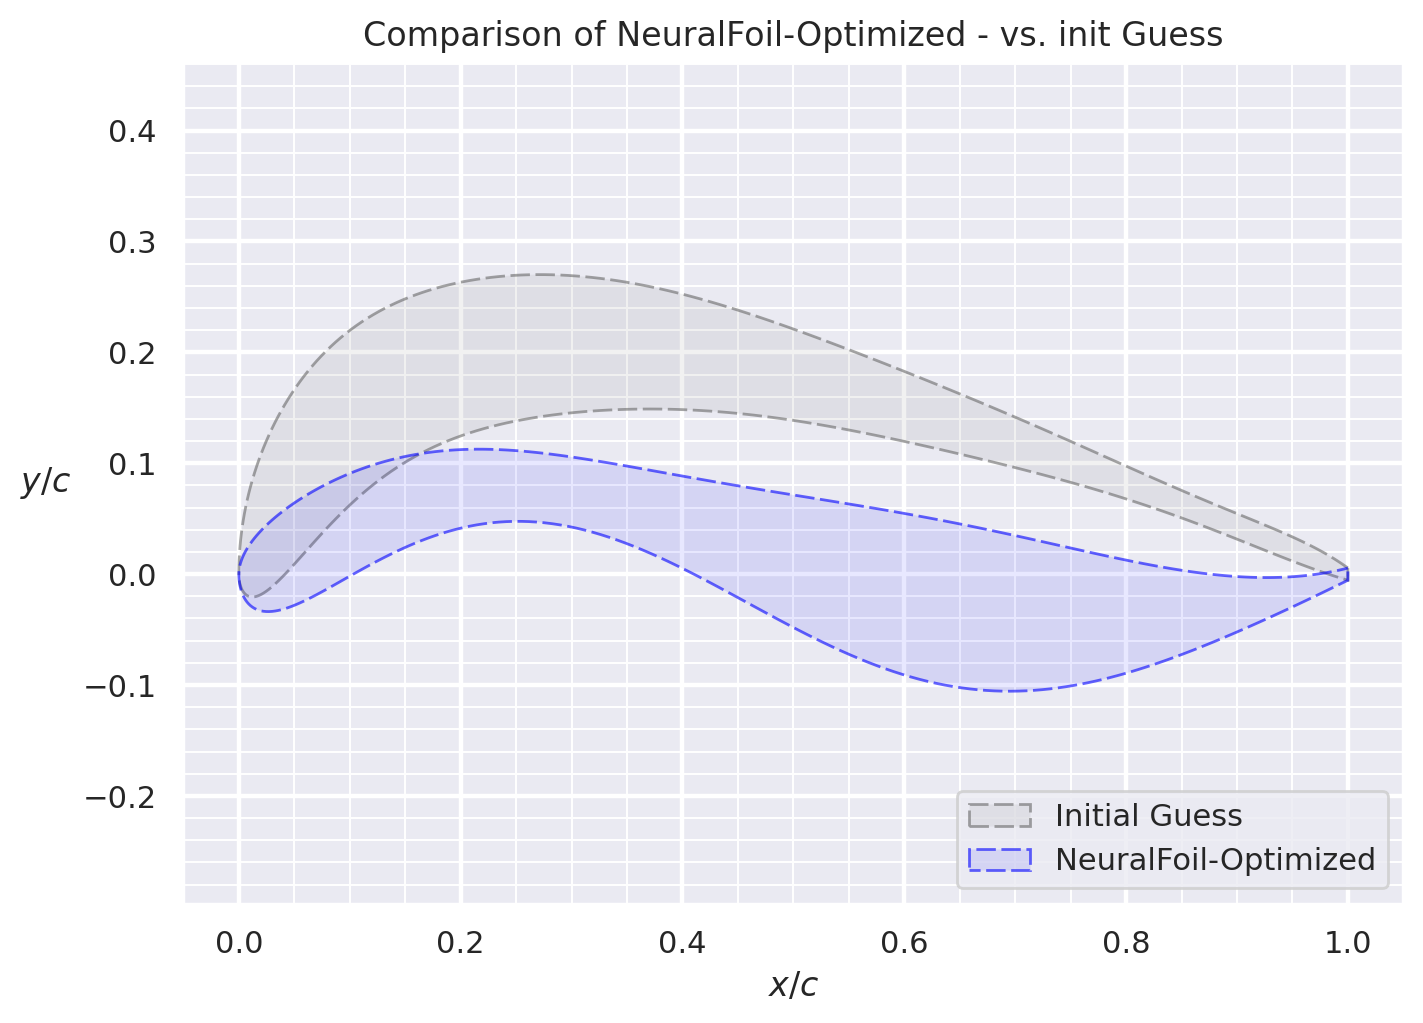

In [66]:
Re_plot = 500e3
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

airfoils_and_colors = {
    "Initial Guess"           : (initial_guess_airfoil, "dimgray"),
    "NeuralFoil-Optimized"    : (optimized_airfoil, "blue")}

for i, (name, (af, color)) in enumerate(airfoils_and_colors.items()):
    color = p.adjust_lightness(color, 1)
    ax.fill(
        af.x(), af.y(),
        facecolor=(*color, 0.09),
        edgecolor=(*color, 0.6),
        linewidth=1,
        label=name,
        linestyle=(3 * i, (7, 2)),
        zorder=4 if "NeuralFoil" in name else 3,
    )

ax.legend(fontsize=11, loc="lower right", ncol=len(airfoils_and_colors)//2)
ax.set_title("Airfoil Shapes")
ax.set_xlabel("$x/c$")
ax.set_ylabel("$y/c$")
ax.axis('equal')

p.show_plot("Comparison of NeuralFoil-Optimized - vs. init Guess", legend=False)